In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch

In [2]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

In [3]:
from pts.model.tempflow import TempFlowEstimator
from pts.model.time_grad import TimeGradEstimator
from pts.model.transformer_tempflow import TransformerTempFlowEstimator
from pts import Trainer

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

In [7]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5']


In [8]:
# exchange_rate_nips, electricity_nips, traffic_nips, solar_nips, wiki-rolling_nips, ## taxi_30min is buggy still
dataset = get_dataset("electricity_nips", regenerate=False)

saving time-series into /Users/lliu/.mxnet/gluon-ts/datasets/electricity_nips/train/data.json
saving time-series into /Users/lliu/.mxnet/gluon-ts/datasets/electricity_nips/test/data.json


In [9]:
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat', cardinality='370')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [11]:
train_grouper = MultivariateGrouper(max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)), 
                                   max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

In [12]:
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

/Users/lliu/code/pytorch-ts/.pts-env3.8/lib/python3.8/site-packages/gluonts/dataset/multivariate_grouper.py:182: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return {FieldName.TARGET: np.array([funcs(data) for data in dataset])}


In [21]:
estimator = TimeGradEstimator(
    target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length,
    cell_type='GRU',
    input_size=1484,
    freq=dataset.metadata.freq,
    loss_type='l2',
    scaling=True,
    diff_steps=100,
    beta_end=0.1,
    beta_schedule="linear",
    trainer=Trainer(device=device,
                    epochs=20,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100,
                    batch_size=64,)
)

In [22]:
predictor = estimator.train(dataset_train, num_workers=8)

99it [00:36,  2.68it/s, avg_epoch_loss=0.78, epoch=0] 
99it [00:37,  2.67it/s, avg_epoch_loss=0.171, epoch=1]
99it [00:36,  2.69it/s, avg_epoch_loss=0.113, epoch=2]
99it [00:36,  2.70it/s, avg_epoch_loss=0.103, epoch=3]
99it [00:37,  2.65it/s, avg_epoch_loss=0.103, epoch=4] 
99it [00:36,  2.68it/s, avg_epoch_loss=0.0922, epoch=5]
99it [00:37,  2.66it/s, avg_epoch_loss=0.0864, epoch=6]
99it [00:36,  2.71it/s, avg_epoch_loss=0.0831, epoch=7]
99it [00:36,  2.68it/s, avg_epoch_loss=0.0809, epoch=8]
99it [00:37,  2.67it/s, avg_epoch_loss=0.0787, epoch=9]
99it [00:36,  2.70it/s, avg_epoch_loss=0.0769, epoch=10]
99it [00:36,  2.72it/s, avg_epoch_loss=0.0752, epoch=11]
99it [00:36,  2.69it/s, avg_epoch_loss=0.0747, epoch=12]
99it [00:36,  2.70it/s, avg_epoch_loss=0.0734, epoch=13]
99it [00:36,  2.70it/s, avg_epoch_loss=0.0732, epoch=14]
99it [00:36,  2.69it/s, avg_epoch_loss=0.0724, epoch=15]
99it [00:36,  2.68it/s, avg_epoch_loss=0.0713, epoch=16]
99it [00:36,  2.70it/s, avg_epoch_loss=0.0711

In [23]:
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                                 predictor=predictor,
                                                 num_samples=100)

In [24]:
forecasts = list(forecast_it)
targets = list(ts_it)

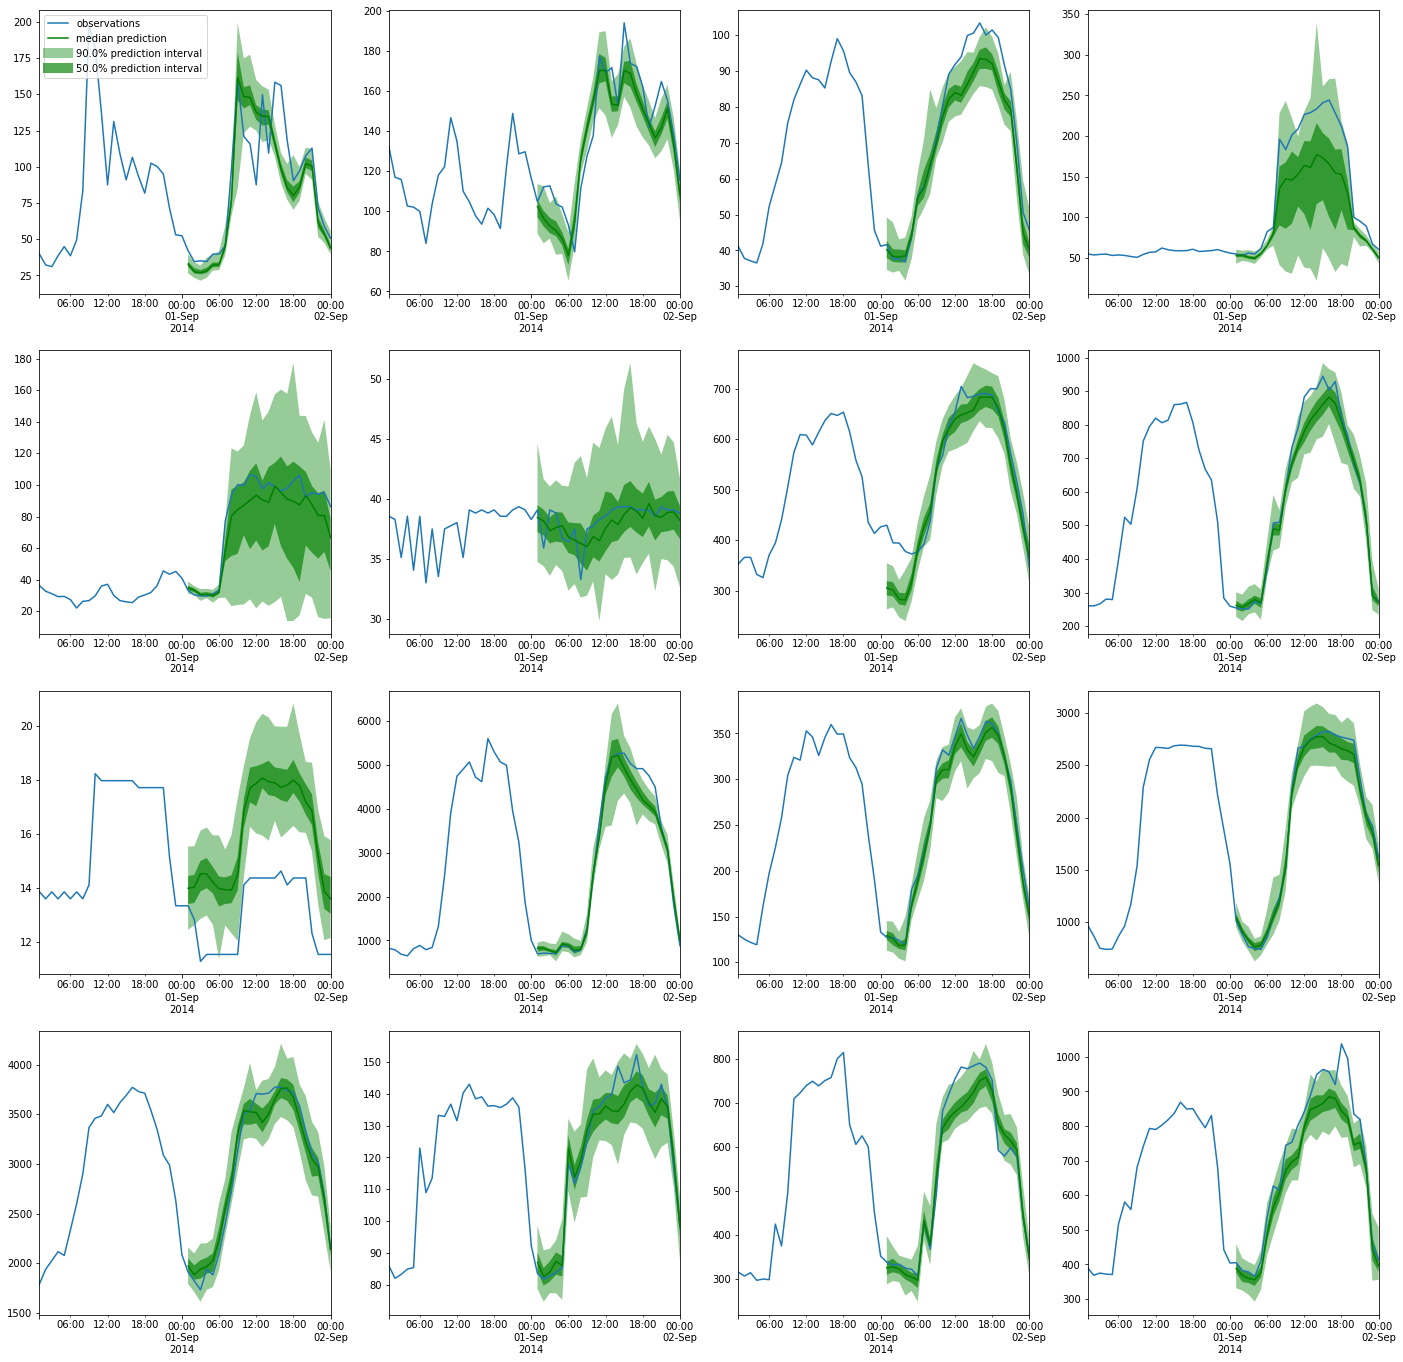

In [25]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)
plt.show()

In [26]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:], 
                                  target_agg_funcs={'sum': np.sum})

In [27]:
agg_metric, item_metrics = evaluator(targets, forecasts, num_series=len(dataset_test))

Running evaluation: 7it [00:00, 72.38it/s]
Running evaluation: 7it [00:00, 77.71it/s]
Running evaluation: 7it [00:00, 75.46it/s]
Running evaluation: 7it [00:00, 76.83it/s]
Running evaluation: 7it [00:00, 73.96it/s]
Running evaluation: 7it [00:00, 77.31it/s]
Running evaluation: 7it [00:00, 76.99it/s]
Running evaluation: 7it [00:00, 77.94it/s]
Running evaluation: 7it [00:00, 77.07it/s]
Running evaluation: 7it [00:00, 76.45it/s]
Running evaluation: 7it [00:00, 76.61it/s]
Running evaluation: 7it [00:00, 75.67it/s]
Running evaluation: 7it [00:00, 77.38it/s]
Running evaluation: 7it [00:00, 76.56it/s]
Running evaluation: 7it [00:00, 76.79it/s]
Running evaluation: 7it [00:00, 77.81it/s]
Running evaluation: 7it [00:00, 77.01it/s]
Running evaluation: 7it [00:00, 75.84it/s]
Running evaluation: 7it [00:00, 75.33it/s]
Running evaluation: 7it [00:00, 76.27it/s]
Running evaluation: 7it [00:00, 74.73it/s]
Running evaluation: 7it [00:00, 77.41it/s]
Running evaluation: 7it [00:00, 76.45it/s]
Running eva

In [28]:
print("CRPS:", agg_metric["mean_wQuantileLoss"])
print("ND:", agg_metric["ND"])
print("NRMSE:", agg_metric["NRMSE"])
print("")
print("CRPS-Sum:", agg_metric["m_sum_mean_wQuantileLoss"])
print("ND-Sum:", agg_metric["m_sum_ND"])
print("NRMSE-Sum:", agg_metric["m_sum_NRMSE"])

CRPS: 0.05053423468691888
ND: 0.06425762218850603
NRMSE: 0.49794260559943126

CRPS-Sum: 0.02014583598885778
ND-Sum: 0.0265341333895826
NRMSE-Sum: 0.03624724117126602
